# Модель VECM (пакет [`statsmodels`](https://www.statsmodels.org/stable/index.html))

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank, select_order

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

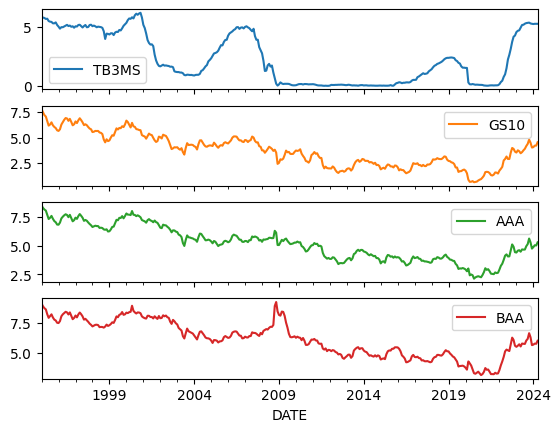

In [2]:
y = web.DataReader(name=['TB3MS', 'GS10', 'AAA', 'BAA'], data_source='fred', start='1995-01-01')

y.plot(subplots=True)
plt.show()

## Тест на коинтеграцию

Используем метод [coint_johansen(endog, det_order, k_ar_diff)](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html#statsmodels.tsa.vector_ar.vecm.coint_johansen)

где 
* `det_order`
	* -1 - no deterministic terms
	* 0 - constant term
	* 1 - linear trend
* `k_ar_diff`: Number of lagged differences in the model

In [3]:
# тест Johansen
coint_res = coint_johansen(y, det_order=0, k_ar_diff=2)

In [4]:
# trace-stat & critical
coint_res.trace_stat, coint_res.trace_stat_crit_vals

(array([58.98756114, 29.29712051, 11.44197894,  4.14983581]),
 array([[44.4929, 47.8545, 54.6815],
        [27.0669, 29.7961, 35.4628],
        [13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]))

In [5]:
# eigenvalue-stat & critical
coint_res.max_eig_stat, coint_res.max_eig_stat_crit_vals

(array([29.69044063, 17.85514157,  7.29214312,  4.14983581]),
 array([[25.1236, 27.5858, 32.7172],
        [18.8928, 21.1314, 25.865 ],
        [12.2971, 14.2639, 18.52  ],
        [ 2.7055,  3.8415,  6.6349]]))

Используем [`select_coint_rank(endog, det_order, k_ar_diff, method='trace', signif=0.05)`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.select_coint_rank.html#statsmodels.tsa.vector_ar.vecm.select_coint_rank)

где 
* `det_order`
	* -1 - no deterministic terms
	* 0 - constant term
	* 1 - linear trend
* `k_ar_diff` - Number of lagged differences in the model
* `method` - выбор тестовой статистики: `trace` или `maxeig`
* `signif` - уровень значимости: 0.1, 0.05, 0.01

In [6]:
# подбор ранга коинтеграции
select_coint_rank(y, det_order=0, k_ar_diff=2, method='trace', signif=0.05).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

## Подгонка VECM

Для автоматического выбора порядка коинтеграции используем [`select_order(data, maxlags, deterministic='n')`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.select_order.html#statsmodels.tsa.vector_ar.vecm.select_order)

где `deterministic` 
* "n" - no deterministic terms
* "co" - constant outside the cointegration relation
* "ci" - constant within the cointegration relation
* "lo" - linear trend outside the cointegration relation
* "li" - linear trend within the cointegration relation

Combinations of these are possible (e.g. "cili" or "colo" for linear trend with intercept)

In [7]:
# выбор порядка лагов для VECM
select_order(y, maxlags=2, deterministic='c').summary()

<class 'statsmodels.iolib.table.SimpleTable'>

Подгонка модели заданного порядка, используем [VECM](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECM.html#statsmodels.tsa.vector_ar.vecm.VECM)

здесь `deterministic` 
* "n" - no deterministic terms
* "co" - constant outside the cointegration relation
* "ci" - constant within the cointegration relation
* "lo" - linear trend outside the cointegration relation
* "li" - linear trend within the cointegration relation

Combinations of these are possible (e.g. "cili" or "colo" for linear trend with intercept)

In [8]:
mod = VECM(y, k_ar_diff=1, coint_rank=1, deterministic='co', missing='drop')

res = mod.fit()

res.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation TB3MS
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1097      0.036      3.016      0.003       0.038       0.181
L1.TB3MS       0.3994      0.055      7.320      0.000       0.292       0.506
L1.GS10        0.0612      0.077      0.794      0.427      -0.090       0.212
L1.AAA        -0.0602      0.124     -0.487      0.627      -0.303       0.182
L1.BAA         0.0369      0.081      0.455      0.649      -0.122       0.196
Det. terms outside the coint. relation & lagged endog. parameters for equation GS10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0763      0.047     -1.612      0.107      -0.169       0.016
L1.TB3MS       0.0126      0.071      0.177      0.860      -0.127       0.152
L1.GS10        0.1954      0.100      1.948      0.051      -0.001       0.392
L1.AAA         0.2916      0.161      1.810      0.070      -0.024       0.607
L1.BAA        -0.2224      0.106     -2.106      0.035      -0.429      -0.015
Det. terms outside the coint. relation & lagged endog. parameters for equation AAA
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0088      0.041     -0.215      0.829      -0.089       0.071
L1.TB3MS       0.0625      0.061      1.024      0.306      -0.057       0.182
L1.GS10       -0.0187      0.086     -0.216      0.829      -0.188       0.150
L1.AAA         0.4331      0.139      3.126      0.002       0.162       0.705
L1.BAA        -0.2425      0.091     -2.670      0.008      -0.421      -0.065
Det. terms outside the coint. relation & lagged endog. parameters for equation BAA
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0289      0.045      0.636      0.525      -0.060       0.118
L1.TB3MS       0.0250      0.068      0.367      0.714      -0.108       0.158
L1.GS10       -0.2571      0.096     -2.672      0.008      -0.446      -0.069
L1.AAA         0.3699      0.154      2.395      0.017       0.067       0.673
L1.BAA         0.1361      0.101      1.344      0.179      -0.062       0.335
               Loading coefficients (alpha) for equation TB3MS                
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.0206      0.007     -3.117      0.002      -0.034      -0.008
                Loading coefficients (alpha) for equation GS10                
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.0132      0.009      1.535      0.125      -0.004       0.030
                Loading coefficients (alpha) for equation AAA                 
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

## Диагностика модели

In [9]:
# тест на серийную корреляцию
res.test_whiteness(nlags=10, signif=0.05, adjusted=True).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

## Прогнозирование

In [10]:
# преобразуем y в формат numpy
res.predict(steps=10)

array([[5.2639138 , 4.61473563, 5.32326219, 6.0468162 ],
       [5.29134772, 4.61676503, 5.32380167, 6.0494271 ],
       [5.3162828 , 4.60225929, 5.31814477, 6.04887649],
       [5.33796982, 4.58434517, 5.31075221, 6.04932237],
       [5.3566754 , 4.56603278, 5.30225787, 6.04954863],
       [5.37272702, 4.5482922 , 5.29318933, 6.0488948 ],
       [5.38642122, 4.53151366, 5.28393449, 6.04727606],
       [5.39803484, 4.51580591, 5.27469009, 6.04478207],
       [5.40782552, 4.50113565, 5.26553201, 6.04152355],
       [5.41602735, 4.48741141, 5.25648043, 6.03760067]])

Визуализация численного прогноза

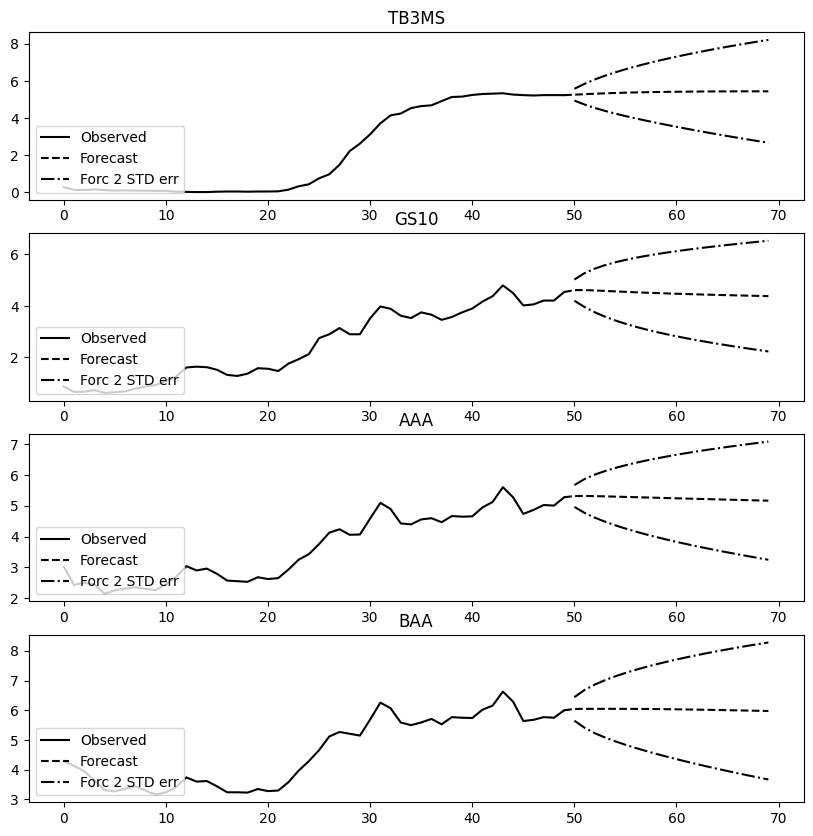

In [11]:
fig = res.plot_forecast(steps=20, alpha=0.05, plot_conf_int=True, n_last_obs=50)

# изменим положение легенды для каждого подграфика
# for i in range(y.shape[1]):
# 	fig.axes[i].legend(loc=3)

plt.show()

## IRF

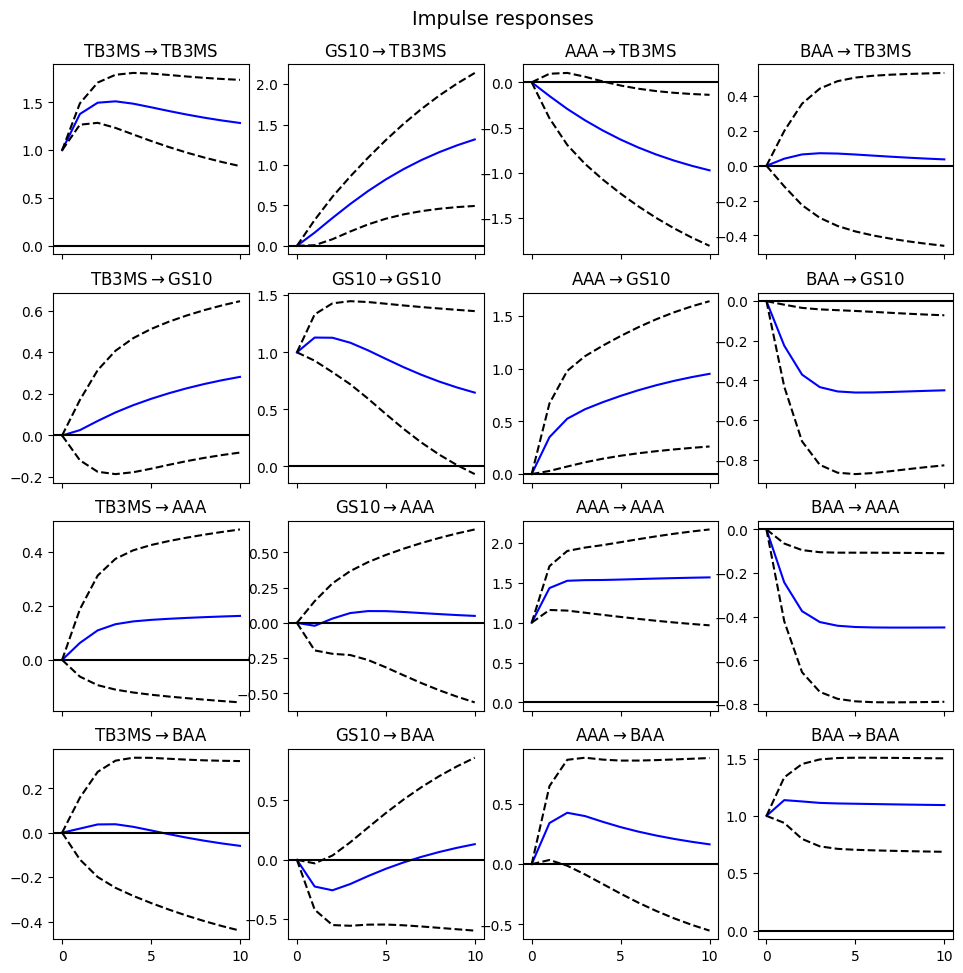

In [12]:
res.irf(periods=10).plot(signif=0.05)
plt.show()

## Причинность

In [13]:
res.test_granger_causality(caused=['AAA', 'BAA'], causing=['TB3MS', 'GS10'], signif=0.01).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [14]:
res.test_granger_causality(caused= ['TB3MS', 'GS10'], causing=['AAA', 'BAA'], signif=0.01).summary()

<class 'statsmodels.iolib.table.SimpleTable'>